In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [14]:
df_history = pd.read_csv('/content/TCS_stock_history.csv')

In [5]:
df_info = pd.read_csv('/content/TCS_stock_history.csv', header=None, index_col=0)

In [11]:
print("--- TCS Stock History Head ---")
print(df_history.head())
print("\n--- TCS Stock History Info ---")
df_history.info()

--- TCS Stock History Head ---
         Date       Open       High        Low      Close  Volume  Dividends  \
0  2002-08-12  28.794172  29.742206  28.794172  29.519140  212976        0.0   
1  2002-08-13  29.556316  30.030333  28.905705  29.119476  153576        0.0   
2  2002-08-14  29.184536  29.184536  26.563503  27.111877  822776        0.0   
3  2002-08-15  27.111877  27.111877  27.111877  27.111877       0        0.0   
4  2002-08-16  26.972458  28.255089  26.582090  27.046812  811856        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

--- TCS Stock History Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4463 non-null   object 
 1   Open          4463 non-null   float64
 2   High          4463 non-null   float64
 3   Low           4463 non

In [26]:
df_history['Date'] = pd.to_datetime(df_history['Date'])
df_history = df_history.set_index('Date')
print("\n--- TCS Stock History Info after Date conversion and setting index ---")
df_history.info()


--- TCS Stock History Info after Date conversion and setting index ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4463 entries, 2002-08-12 to 2021-09-30
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          4463 non-null   float64
 1   High          4463 non-null   float64
 2   Low           4463 non-null   float64
 3   Close         4463 non-null   float64
 4   Volume        4463 non-null   int64  
 5   Dividends     4463 non-null   float64
 6   Stock Splits  4463 non-null   float64
 7   Log_Return    4462 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 313.8 KB


In [19]:
annual_volatility = (
    df_history['Log_Return']
    .groupby(df_history['Date'].dt.year)
    .std() * np.sqrt(252)
).to_frame(name='Annualized Volatility')
annual_volatility.index.name = 'Year'

In [21]:
df_history_indexed = df_history.set_index('Date')
yearly_returns = (
    df_history_indexed['Close']
    .resample('YE')
    .ffill()  # Use forward fill to get the last price of the year
    .pct_change() * 100
).dropna().to_frame(name='Yearly Return (%)')
yearly_returns.index = yearly_returns.index.year
yearly_returns.index.name = 'Year'
display(yearly_returns)

,Yearly Return (%)
Year,
2003,-36.140608
2004,336.009128
2005,28.905778
2006,44.834391
2007,-10.869012
2008,-54.799717
2009,209.050710
2010,64.206342
2011,0.963898


In [23]:
performance_analysis = yearly_returns.merge(annual_volatility, on='Year')

In [27]:
df_yearly_trend = df_history[['Close', 'Volume']].resample('YE').agg({
    'Close': 'last',  # Last close price of the year
    'Volume': 'sum'    # Total volume traded in the year
})
df_yearly_trend.index = df_yearly_trend.index.year
df_yearly_trend.index.name = 'Year'

In [28]:
df_yearly_trend = df_history[['Close', 'Volume']].resample('YE').agg({
    'Close': 'last',  # Last close price of the year
    'Volume': 'sum'    # Total volume traded in the year
})
df_yearly_trend.index = df_yearly_trend.index.year
df_yearly_trend.index.name = 'Year'

print("\n--- Yearly Close Price and Total Volume (Last 10 Years) ---")
print(df_yearly_trend.tail(10).round(2))


--- Yearly Close Price and Total Volume (Last 10 Years) ---
        Close     Volume
Year                    
2012   526.24  667246580
2013   924.30  674954682
2014  1120.47  578958206
2015  1088.79  580144728
2016  1076.14  539221804
2017  1253.03  548139150
2018  1782.43  849403971
2019  2102.14  735316589
2020  2837.21  999223368
2021  3773.20  521917940


In [29]:
stock_splits = df_history[df_history['Stock Splits'] > 1.0][['Stock Splits', 'Close']].reset_index()
stock_splits.rename(columns={'Close': 'Closing Price on Split Day'}, inplace=True)

In [30]:
print("--- Major Stock Split Events ---")
print(stock_splits)

--- Major Stock Split Events ---
        Date  Stock Splits  Closing Price on Split Day
0 2006-07-28           2.0                  176.048447
1 2009-06-16           2.0                  154.362122
2 2018-05-31           2.0                 1632.574219


In [31]:
significant_dividends = df_history[df_history['Dividends'] > 0.0].sort_values(by='Dividends', ascending=False).head(5)
significant_dividends = significant_dividends[['Dividends', 'Close']].reset_index()
significant_dividends.rename(columns={'Close': 'Closing Price on Ex-Dividend Date'}, inplace=True)

In [32]:
print("\n--- Top 5 Largest Dividend Payouts ---")
print(significant_dividends)



--- Top 5 Largest Dividend Payouts ---
        Date  Dividends  Closing Price on Ex-Dividend Date
0 2019-10-17       40.0                        1974.992188
1 2014-07-28       20.0                        1131.783203
2 2019-06-04       18.0                        2076.603516
3 2021-05-25       15.0                        3107.218994
4 2018-05-31       14.5                        1632.574219


In [33]:
df_history['SMA_30'] = df_history['Close'].rolling(window=30).mean()
df_history['EMA_30'] = df_history['Close'].ewm(span=30, adjust=False).mean()


In [34]:
last_year = df_history.iloc[-252:].copy()

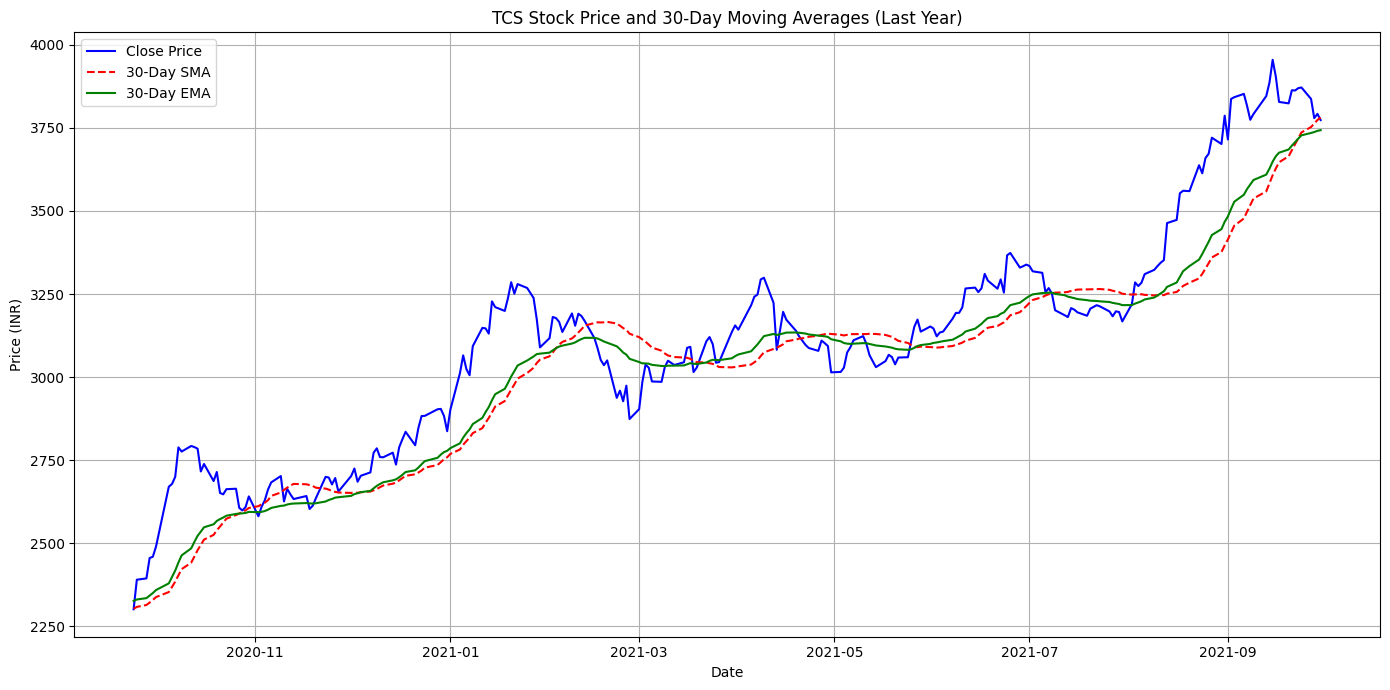

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(last_year.index, last_year['Close'], label='Close Price', color='blue')
plt.plot(last_year.index, last_year['SMA_30'], label='30-Day SMA', color='red', linestyle='--')
plt.plot(last_year.index, last_year['EMA_30'], label='30-Day EMA', color='green')

plt.title('TCS Stock Price and 30-Day Moving Averages (Last Year)')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [36]:
plot_filename = 'TCS_SMA_EMA_Trend.png'
plt.savefig(plot_filename)
plt.close()

In [37]:
short_term_forecast = last_year[['Close', 'SMA_30', 'EMA_30']].tail(10)
short_term_forecast.index = short_term_forecast.index.strftime('%Y-%m-%d')
short_term_forecast.index.name = 'Date'


In [38]:
print(f"Plot saved as {plot_filename}")
print("\n--- Short-Term Trend Indicators (Last 10 Days) ---")
print(short_term_forecast.round(2))

Plot saved as TCS_SMA_EMA_Trend.png

--- Short-Term Trend Indicators (Last 10 Days) ---
              Close   SMA_30   EMA_30
Date                                 
2021-09-17  3827.85  3646.31  3675.18
2021-09-20  3823.50  3664.29  3684.75
2021-09-21  3862.95  3682.73  3696.24
2021-09-22  3862.15  3700.71  3706.95
2021-09-23  3869.25  3718.56  3717.42
2021-09-24  3871.30  3736.13  3727.35
2021-09-27  3836.95  3752.30  3734.42
2021-09-28  3779.15  3762.83  3737.30
2021-09-29  3791.90  3773.46  3740.83
2021-09-30  3773.20  3780.80  3742.91


In [40]:
short_term_forecast.to_csv('TCS_short_term_forecast.csv')

In [44]:
data = df_history['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [46]:
training_data_len = int(len(scaled_data) * 0.8)  # 80% for training

In [47]:
time_step = 60

In [48]:
def create_sequences(data, time_step):
    X, Y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_sequences(scaled_data[:training_data_len], time_step)

In [49]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [53]:
model = Sequential()

In [54]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

In [58]:
model.add(Dense(units=1))

In [59]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0041
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 2.9233e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 2.5450e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 2.3515e-04
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 2.3839e-04
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 1.9216e-04
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1.8820e-04
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.7787e-04
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 1.6182e-04
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.3225e-04
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 1.4456e-04
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.2951e-04
Epoch 13/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.3205e-04
Epoch 14/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - lo

In [60]:
test_data = scaled_data[training_data_len - time_step:, :] # Include past 60 days for first prediction
X_test, y_test = create_sequences(test_data, time_step)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [61]:
predictions = model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [62]:
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


In [63]:
rmse = np.sqrt(np.mean(predictions - y_test_actual)**2)
print(f"Test RMSE: {rmse:.2f}")


Test RMSE: 27.68
